In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image, ImageDraw

In [2]:
def findAreaCentroidPoint(im):
    immat = im.load()
    (X, Y) = im.size
    m = np.zeros((X, Y))

    for x in range(X):
        for y in range(Y):
            m[x, y] = immat[(x, y)] != 1
    m = m / np.sum(np.sum(m))
    # marginal distributions
    dx = np.sum(m, 1)
    dy = np.sum(m, 0)

    # expected values
    cx = np.sum(dx * np.arange(X))
    cy = np.sum(dy * np.arange(Y))

    return (cx-100,cy)


row count :  1280  col count :  1029


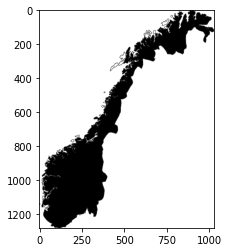

In [3]:
# img = mpimg.imread("norway-23574_1280.png")
image = Image.open("norway-23574_1280.png").convert("L")
# image = Image.open("imgs/india-map.jpg").convert("L")

col_count, row_count = image.size

print("row count : ", row_count, " col count : ", col_count)
cords = [
    (0,0),                  # top left
    (col_count, 0),         # top right
    (col_count, row_count), # bottom right
    (0, row_count),         # bottom left
]

centroid = findAreaCentroidPoint(image)
start_point = centroid
color = (128, 128, 128, 255)
img_draw = ImageDraw.floodfill(image, start_point, 0, thresh=50)
image.save('gray_marked_image.png')
img = mpimg.imread("gray_marked_image.png")
plt.imshow(img, cmap='gray')

In [4]:
def markPoints(plt, x_coordinates, y_coordinates, point_size=100, color="#00f"):
    plt.scatter(x_coordinates, y_coordinates, s=point_size, c=color)
    # rect = patches.Rectangle((x, y), length, length, linewidth=width, edgecolor=edgeColor, facecolor='none')
    # return rect

In [5]:
def findCentroidPoint(cords):
    x_points_count = 0
    y_points_count = 0
    x_points_sum = 0
    y_points_sum = 0
    # summation of x and y
    for points in cords:
        x_points_sum += points[0]
        y_points_sum += points[1]
        y_points_count += 1
        x_points_count += 1
    # centroid: summation divided by number of nodes      
    center = (x_points_sum/x_points_count, y_points_sum/y_points_count)
    # a       e          b
    # h   centroid(z)    f
    # d       g          c
    #
    # e = (xz, ya)
    # f = (xb, yz)
    # g = (xz, yc)
    # h = (xd, yz)
    #
    # e
    top = (center[0], cords[0][1])
    # f
    right = (cords[1][0], center[1])
    # g
    bottom = (center[0], cords[2][1])
    # h
    left = (cords[3][0], center[1])
    # {"center" : z, "border" : (e, f, g, h)}     
    return {"center" : center, "border" : (top, right, bottom, left)}
    
def divideBoxs(cords):
    centroid = findCentroidPoint(cords)
    boxes = []
    # top left box (a, e, z, h)
    boxes.append([ cords[0], centroid['border'][0], centroid['center'] ,  centroid['border'][3] ]);
    # top right box (e, b, f, z)
    boxes.append([ centroid['border'][0], cords[1], centroid['border'][1], centroid['center'] ]);
    # bottom right box (z, f, c, g)
    boxes.append([ centroid['center'], centroid['border'][1], cords[2], centroid['border'][2] ]);
    # bottom left box (h, z, g, d)
    boxes.append([ centroid['border'][3], centroid['center'], centroid['border'][2], cords[3] ]);
    return boxes

def drawLine ( plt, x, y, color):
    plt.plot([x[0],y[0]], [x[1],y[1]], c=color, linewidth=1)

def drawSingleBox(plt, box, color="#f00"):
    i = 0
    first_point = None
    past_point = None
    while(i < 4):
        if(i==0):
            first_point = box[i]
            past_point = box[i]
            i += 1
            continue
        drawLine(plt, past_point, box[i], color)
        past_point = box[i]
        i += 1
        # break
    drawLine(plt, past_point, first_point, color)
        # break

def mergeBoxes(old_boxes, new_box):
    old_boxes.append(new_box)
    return old_boxes
    # # print("Boxes: ", old_boxes)
    # # return old_boxes

    # if(len(old_boxes) < 1):
    #     old_boxes.append(new_box)
    #     return old_boxes
    
    # tmp_old_boxes = old_boxes.copy()
    # insert_index = None
    # tmp = []
    # matched = False
    # for index,old_box in enumerate(tmp_old_boxes):
    #     # check right two points of first box with ledt elements of new boxes
    #     if(old_box[0][0]==new_box[0][0]):
    #         matched = True
    #         # print("x match: ",old_box, new_box)
    #     else:
    #         if(matched):
    #             insert_index = index+1
    #             matched = False        
    # if (insert_index):
    #     old_boxes.insert(index+1, new_box)
    # else:
    #     old_boxes.append(new_box)
    # return old_boxes
    

# recursion function
def divideMap (img, box, limit=0):
    if(limit==0):
        return box
    if(limit==1):
        allBoxes = []
        finalBoxes = divideBoxs(box)
        allBoxes.append(box)
        return finalBoxes
    # to store parent box     
    allBoxes = [box]
    allBoxes = []
    intermediateBoxes = divideBoxs(box)
    for intermediateBox in intermediateBoxes:
        intermediateSubBoxes = divideMap(img, intermediateBox, limit-1)
        for intermediateSubBox in intermediateSubBoxes:
            if(hasBorder(img, intermediateSubBox)):
                allBoxes = mergeBoxes(allBoxes, intermediateSubBox)
    return allBoxes
    
def hasBorder(img, reference):
    x_start = int(reference[0][0])-1
    x_end = int(reference[1][0])-1
    y_start = int(reference[0][1])-1
    y_end = int(reference[3][1])-1
    x_index = x_start
    y_index = y_start
    while(x_index < x_end):
        y_index = y_start
        while(y_index < y_end):
            if(img[y_index][x_index]==0):
                return True
            y_index +=1
        x_index +=1 
    return False

row count :  1280  col count :  1029


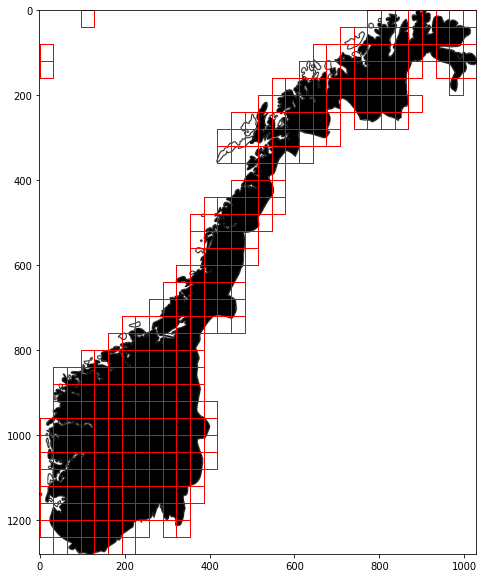

In [9]:
img_t = img.copy()
row_count = len(img_t)    # row count
col_count = len(img_t[0]) # col count
print("row count : ", row_count, " col count : ", col_count)
cords = [
    (0,0),                  # top left
    (col_count, 0),         # top right
    (col_count, row_count), # bottom right
    (0, row_count),         # bottom left
]
# print(allBoxes)
allBoxes = divideMap(img, cords, limit=5)

plt.figure(figsize = (20,10))

i = 0
for boundary in allBoxes:    
    # if(i>2):
    #     break
    drawSingleBox(plt, boundary)
    i += 1
plt.imshow(image, cmap='gray')